## Importing Libraries and Dataset

In [48]:
import numpy as np
import pandas as pd
import os
import optuna
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.model_selection import cross_val_score,KFold,train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

In [4]:
def list_of_all_data(path):
    
    files = [] 
    for i in os.listdir(path): 
        if i.endswith('.txt'):
            with open(os.path.join(path, i),'r') as f:
                files.append(f.read())

    sec_list = ''.join(files).split('\n')
    
    third_list = list(map(lambda each:each.strip(','), sec_list))
    final_list = list(map(lambda each:each.replace(' ',''), third_list))
    
    final_list.pop(-1)
    
    return final_list

path = r'C:/Users/trash/Downloads/Projects/Upspot_Softech_Private_Limited/s3Files'
phase_values = list_of_all_data(path)

In [5]:
def list_to_df(phase_values):
    
    df = pd.DataFrame(phase_values,columns =['Phase_1'])
    
    df[['First_Phase', 'Second_Phase', 'Third_Phase']] = df.Phase_1.str.split(",", expand = True)
    
    df = df.drop('Phase_1',axis = 1)
    
    df = df.astype(int)
    
    return df

data = list_to_df(phase_values)

#### Observations
1. All the given text files are combined to form a single list of values of 3 phases with removing extra punctuations, spaces.
2. Transformed the list of all readings to a pandas DataFrame and stored into a variable.

## Exploratory Data Analysis

In [6]:
new_data = data.drop(data[data.duplicated()].index, axis = 0)

In [7]:
new_data.isnull().sum()

First_Phase     0
Second_Phase    0
Third_Phase     0
dtype: int64

In [8]:
for i in new_data.columns:
    print(new_data[i].value_counts())

1749    8036
2216    7921
2217    7908
1751    7833
2213    7779
        ... 
1685       1
1689       1
1691       1
1693       1
2292       1
Name: First_Phase, Length: 602, dtype: int64
2397    6831
2395    6497
2400    6479
1919    6477
2399    6461
        ... 
2497       1
1863       1
1865       1
1866       1
2485       1
Name: Second_Phase, Length: 625, dtype: int64
776    4559
778    4503
96     4422
780    4419
777    4378
       ... 
906       1
904       1
903       1
902       1
907       1
Name: Third_Phase, Length: 908, dtype: int64


In [9]:
new_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1304553 entries, 0 to 3169998
Data columns (total 3 columns):
 #   Column        Non-Null Count    Dtype
---  ------        --------------    -----
 0   First_Phase   1304553 non-null  int32
 1   Second_Phase  1304553 non-null  int32
 2   Third_Phase   1304553 non-null  int32
dtypes: int32(3)
memory usage: 24.9 MB


In [10]:
new_data.iloc[:, :].describe().T.sort_values(by='std' , ascending = False)\
                     .style.background_gradient(cmap='GnBu')\
                     .bar(subset=["max"], color='#BB0000')\
                     .bar(subset=["mean",], color='green')

,count,mean,std,min,25%,50%,75%,max
Third_Phase,1304553.000000,434.246394,269.675336,0.000000,159.000000,436.000000,711.000000,907.000000
Second_Phase,1304553.000000,2168.265719,180.536278,1863.000000,1980.000000,2169.000000,2357.000000,2497.000000
First_Phase,1304553.000000,1982.526351,180.317061,1681.000000,1795.000000,1982.000000,2171.000000,2292.000000


#### Observations
1. Removed a lot of Duplicates(approx, 18 lacs of rows of data) from the dataset cause they would not add any value to our 
   model.
2. Dataset doesn't contain any null values and all 3 readings are of integer data type.

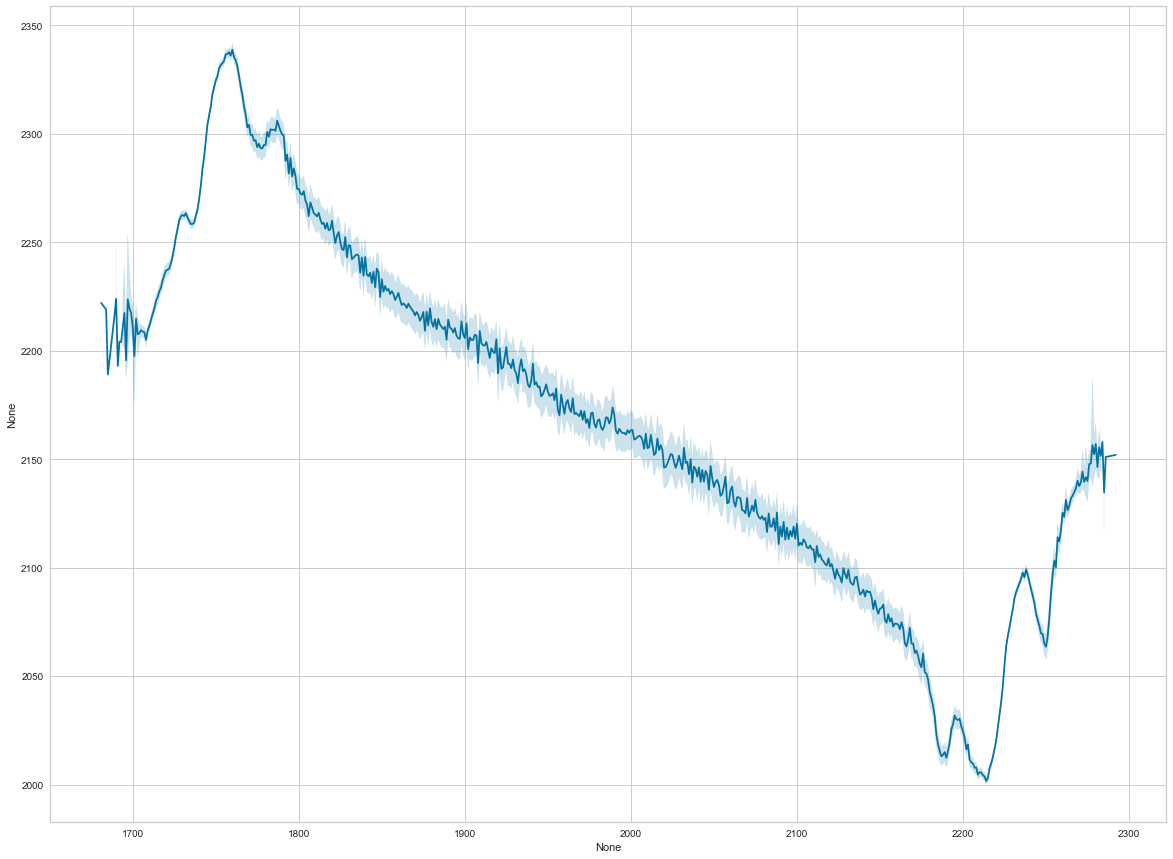

In [11]:
plt.figure(figsize = (20, 15))
sns.lineplot(x = np.array(new_data['First_Phase']),y = np.array(new_data['Second_Phase']))
plt.show()

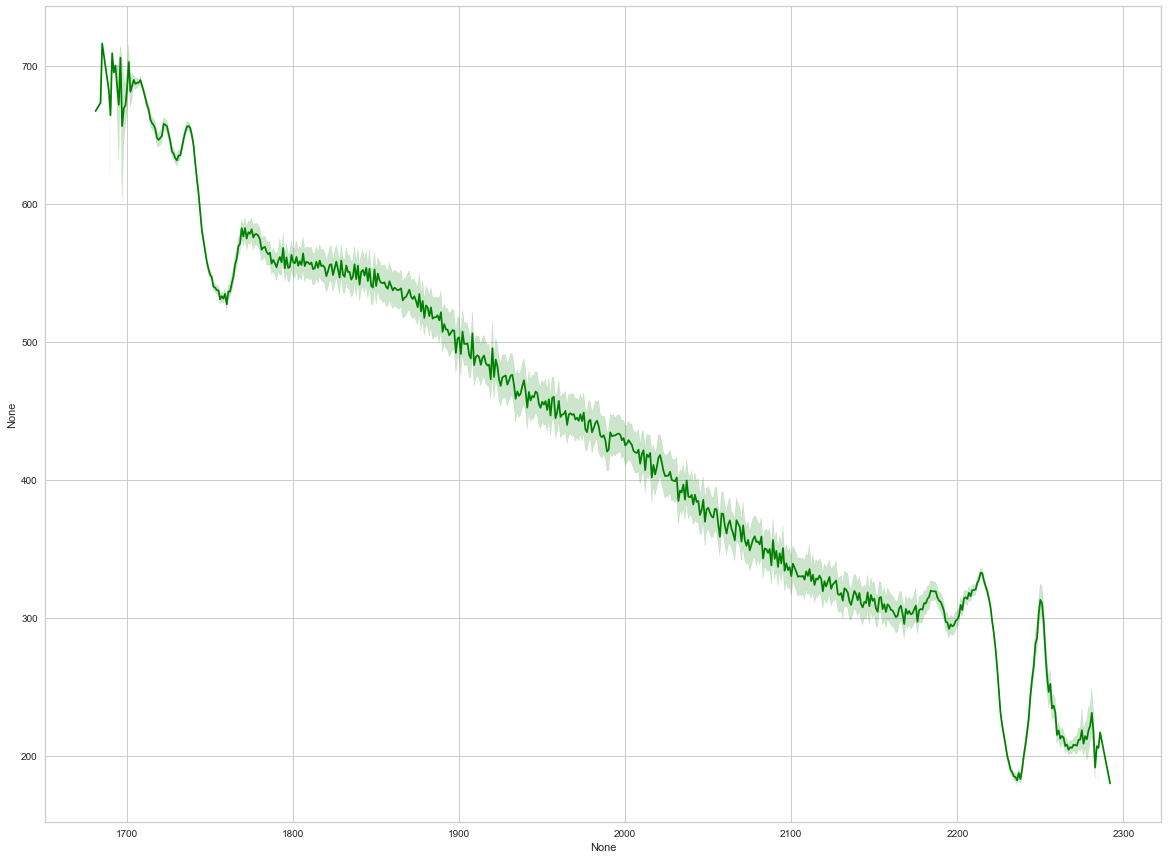

In [12]:
plt.figure(figsize = (20, 15))
sns.lineplot(x = np.array(new_data['First_Phase']),y = np.array(new_data['Third_Phase']),color = 'green')
plt.show()

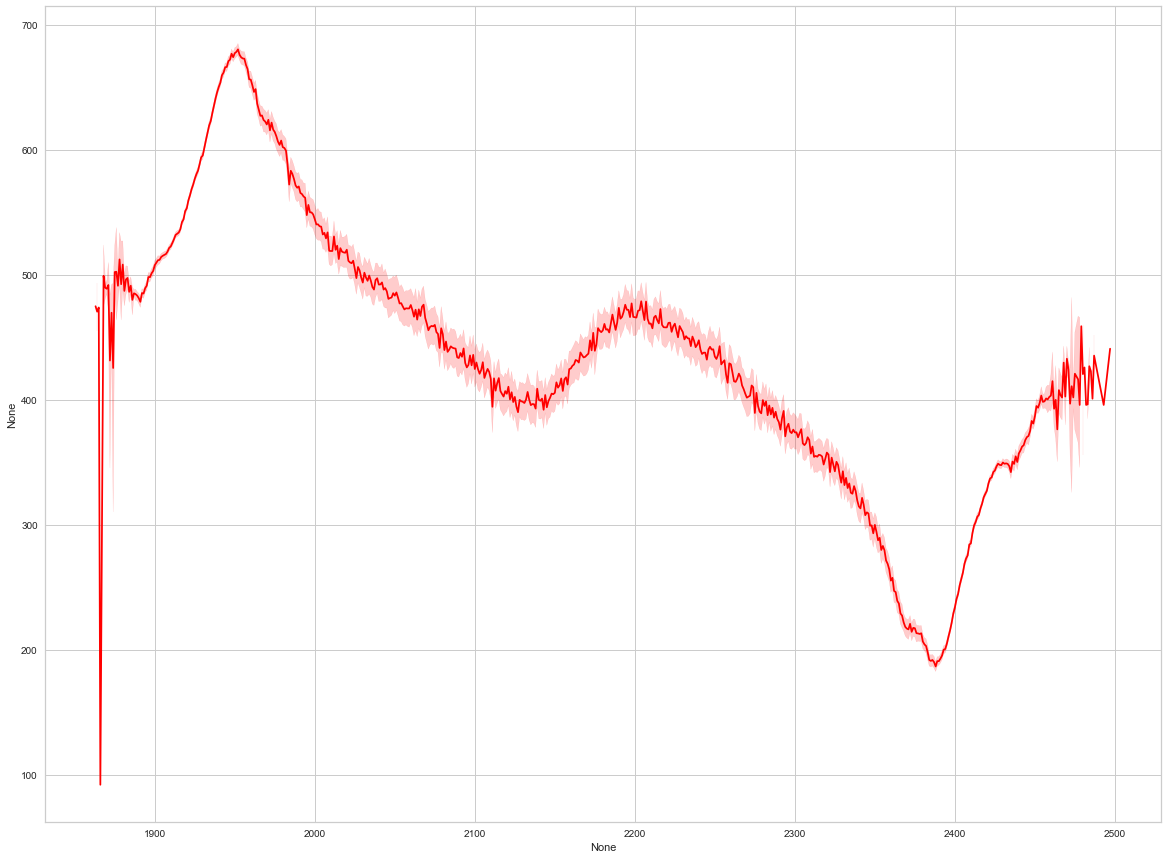

In [13]:
plt.figure(figsize = (20, 15))
sns.lineplot(x = np.array(new_data['Second_Phase']),y = np.array(new_data['Third_Phase']),color = 'red')
plt.show()

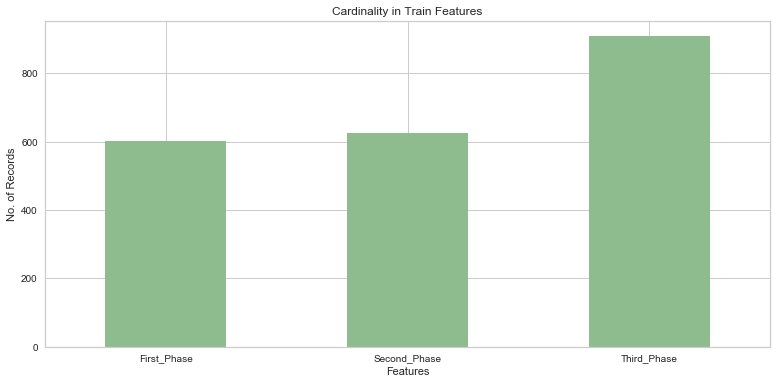

In [14]:
plt.figure(figsize = (13, 6))
new_data.nunique().plot.bar(title="Cardinality in Train Features",width = 0.5,color = 'darkseagreen')
plt.xticks(rotation = 0)
plt.ylabel("No. of Records")
plt.xlabel("Features")
plt.show()

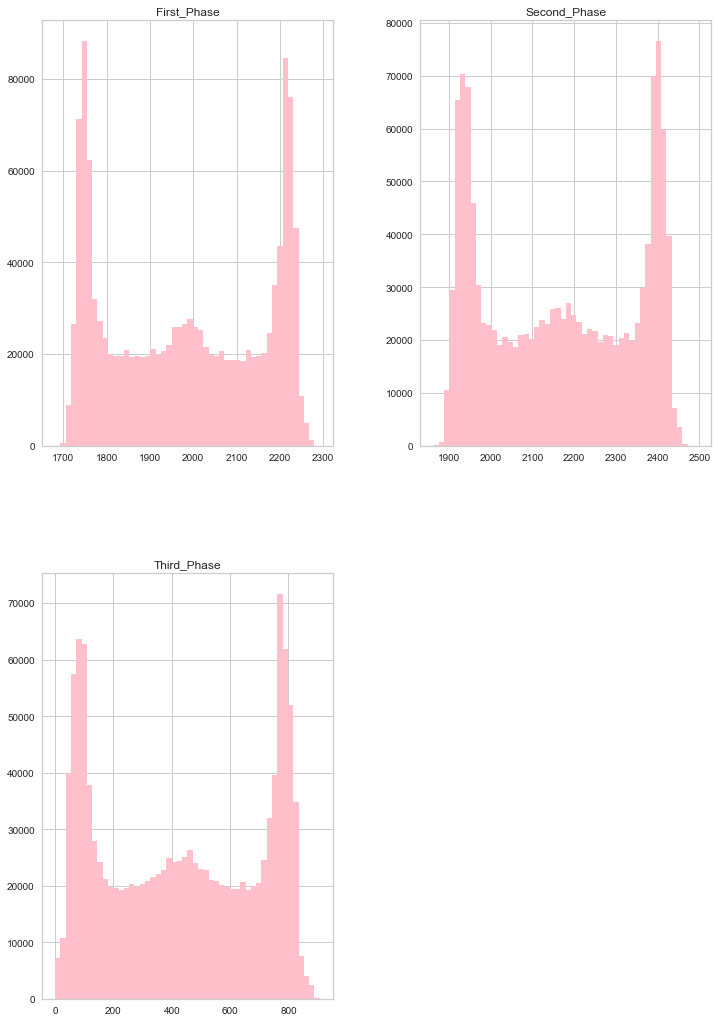

In [15]:
new_data.hist(figsize=(12, 18), bins=50, xlabelsize=10, ylabelsize=10,color='pink');

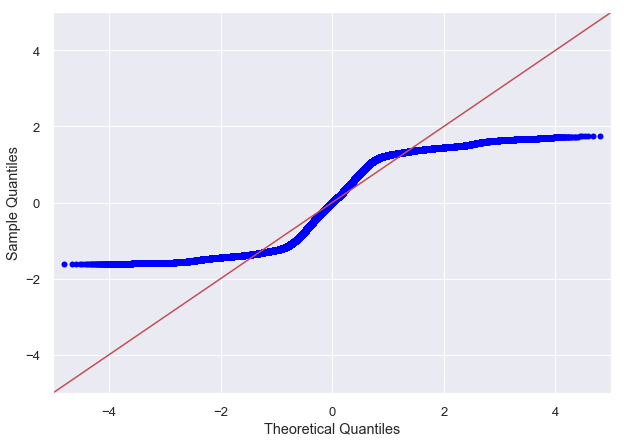

In [24]:
fig4 = sns.set(font_scale=1.2,
               style = 'darkgrid',
               rc={"figure.figsize": [10, 7]})
fig4 = sm.qqplot(new_data['Third_Phase'],line='45',fit=True,dist=stats.norm)
plt.show()

In [17]:
first_percentile_q1_1 = new_data['First_Phase'].quantile(0.25)
third_percentile_q3_1 = new_data['First_Phase'].quantile(0.75)
iqr = third_percentile_q3_1 - first_percentile_q1_1

min_threshold_weight_1 = first_percentile_q1_1 - 1.5 * iqr
max_threshold_weight_1 = third_percentile_q3_1 + 1.5 * iqr

outliers_first = new_data[(new_data['First_Phase']<min_threshold_weight_1)|(new_data['First_Phase']>max_threshold_weight_1)]

In [18]:
outliers_first.shape

(0, 3)

In [19]:
first_percentile_q1_2 = new_data['Second_Phase'].quantile(0.25)
third_percentile_q3_2 = new_data['Second_Phase'].quantile(0.75)
iqr = third_percentile_q3_2 - first_percentile_q1_2

min_threshold_weight_2 = first_percentile_q1_2 - 1.5 * iqr
max_threshold_weight_2 = third_percentile_q3_2 + 1.5 * iqr

outliers_sec = new_data[(new_data['Second_Phase']<min_threshold_weight_2)|(new_data['Second_Phase']>max_threshold_weight_2)]

In [20]:
outliers_sec.shape

(0, 3)

In [21]:
first_percentile_q1_3 = new_data['Third_Phase'].quantile(0.25)
third_percentile_q3_3 = new_data['Third_Phase'].quantile(0.75)
iqr = third_percentile_q3_3 - first_percentile_q1_3

min_threshold_weight_3 = first_percentile_q1_3 - 1.5 * iqr
max_threshold_weight_3 = third_percentile_q3_3 + 1.5 * iqr

outliers_third = new_data[(new_data['Third_Phase']<min_threshold_weight_3)|(new_data['Third_Phase']>max_threshold_weight_3)]

In [22]:
outliers_third.shape

(0, 3)

#### Observations
1. Nothing is Prominent from the lineplot graphs but we can conclude that in the middle readings are much more consistent apart
   apart from starting and ending phase of readings.
2. 'Third_Phase' readings have the highest cardinality in it.
3. From the histograms we can say that all 3 features have multi modal and not normal data which peaks at start and at the end    and giving a rather linear flow in between with a small bump of data.
4. It is clear from QQ plot that none of the features follow Normal Distribution.
5. We checked for the Outliers using IQR technique and no outliers as such exist in the dataset.

## Performing Clustering Techniques to know the number of clusters required for the data.

Elbow Method to determine the number of clusters to be formed:


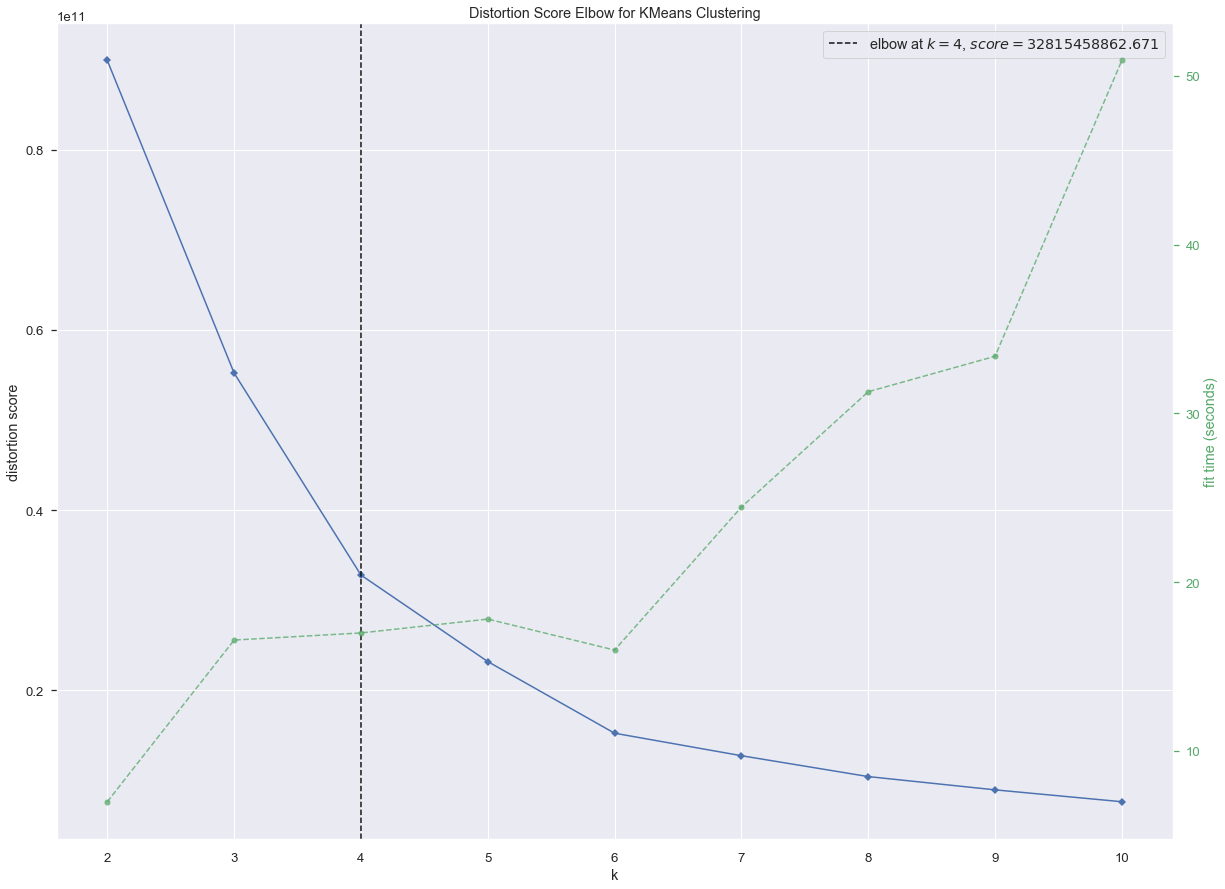

In [25]:
plt.figure(figsize = (20, 15))
print('Elbow Method to determine the number of clusters to be formed:')
Elbow_M = KElbowVisualizer(KMeans(), k=10)
Elbow_M.fit(new_data)
Elbow_M.show()

In [26]:
kmeans = KMeans(n_clusters=4,random_state=57)

label = kmeans.fit_predict(new_data)

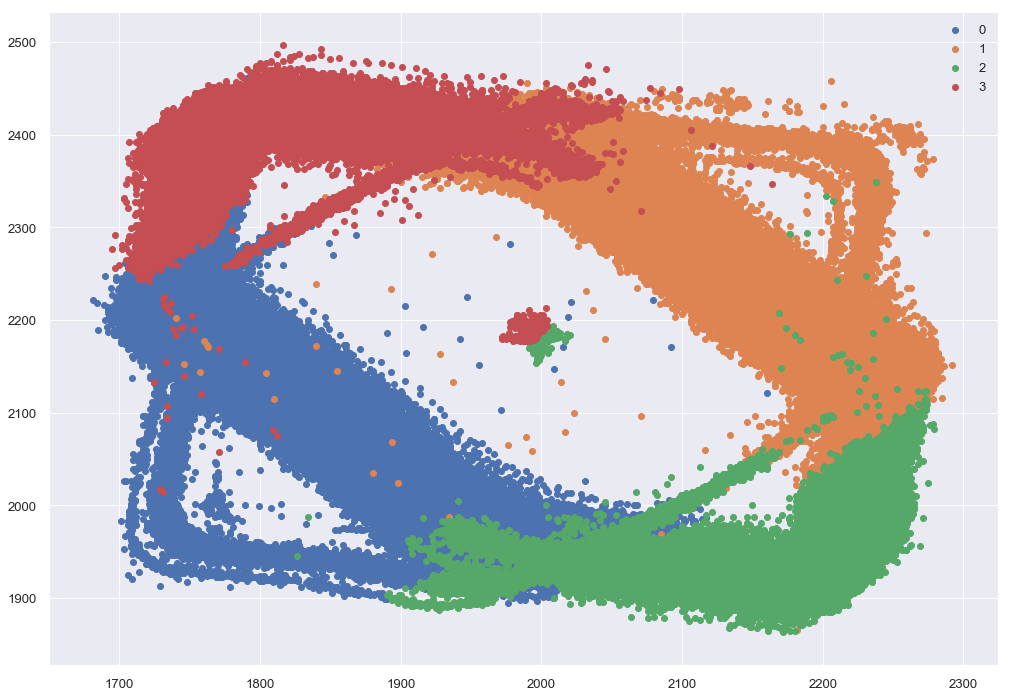

In [27]:
u_labels = np.unique(label)

#plotting the results:
plt.figure(figsize = (17, 12))
for i in u_labels:
    plt.scatter(new_data.iloc[label == i , 0] , new_data.iloc[label == i , 1] , label = i)
plt.legend()
plt.show()

#### Observations
1. Applied KMeans Clustering Algorithm to carry out meaning full insights from data but we were unable to make some                understandings from these clusters.
2. Total 4 clusters are made which from figure shows that Cluster_0 has the highest number of data points whereas all other
   clusters being of almost similar sizes with all of them having atleast 20% of overlapping data points adjacent to them.

## Data Preprocessing and Feature Engineering

In [28]:
def new_df(new_data):
    
    data = new_data.copy()
    # Getting full supply of Current
    data['Full_Current(Amp)'] = data['First_Phase'] + data['Second_Phase'] + data['Third_Phase']
    
    # Calculating Voltage using the P = V * I formula where P is Power for 3.2 horsepower changed to watts i.e 2386.24 watts.
    data['Voltage(volts)'] = 2386.24/data['Full_Current(Amp)']
    
    # Calculating Resistance using V = I * R formula where Voltage and Current has already been calculated earlier.
    data['Resistance(ohm)'] = data['Voltage(volts)']/data['Full_Current(Amp)']
    
    # Creating a new Feature which inturn is a label which tells us whether the resistance of reading is below mean and above 80th percentile value resistance and assigning them binary values. 
    data['Motor_Breakdown(Probable)'] = np.where((data['Resistance(ohm)'] <= 0.0001137219) | (data['Resistance(ohm)'] >= 0.00013),1,0)
    
    return data

new_data = new_df(new_data)    

In [34]:
new_data['Motor_Breakdown(Probable)'].value_counts()

1    670889
0    633664
Name: Motor_Breakdown(Probable), dtype: int64

In [35]:
new_data.head()

,First_Phase,Second_Phase,Third_Phase,Full_Current(Amp),Voltage(volts),Resistance(ohm),Motor_Breakdown(Probable)
0,2040,2361,38,4439,0.537563,0.000121,0
1,2031,2365,52,4448,0.536475,0.000121,0
2,2031,2370,53,4454,0.535752,0.000120,0
3,2025,2372,54,4451,0.536113,0.000120,0
4,2023,2379,54,4456,0.535512,0.000120,0


## Splitting the Dataset into features and labels and changing scales of features.

In [36]:
X = new_data.drop('Motor_Breakdown(Probable)',axis = 1)
y = new_data['Motor_Breakdown(Probable)']

In [37]:
sts = StandardScaler()

new_X = pd.DataFrame(sts.fit_transform(X), columns=X.columns)

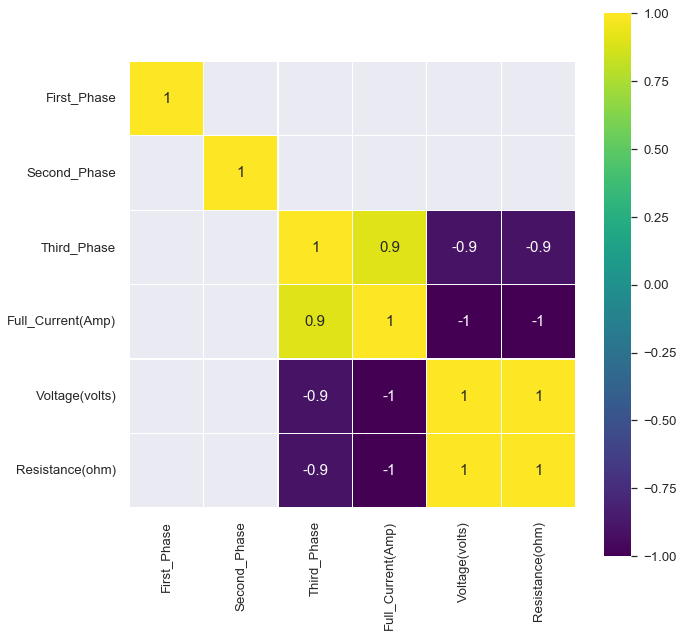

In [39]:
corr = new_X.corr()
plt.figure(figsize=(10, 10))

sns.heatmap(corr[(corr >= 0.8) | (corr <= -0.8)], 
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 15}, square=True);

In [41]:
X_new = new_X.drop(['Third_Phase','Voltage(volts)','Full_Current(Amp)'],axis = 1)

#### Observations
1. We converted all features so that they are on same scale and no misleads occur in the model building using Standard Scaler.
2. Printing the Correlation matrix which shows which features are correlated to each other.
3. We removed all the features which have a correlation more than 0.8 and less than -0.8.

## Choosing the best algorithm for model building

In [44]:
classifiers = [LogisticRegression(),KNeighborsClassifier(),GaussianNB(),DecisionTreeClassifier()
             ,GradientBoostingClassifier()]

clf_dict = {0:'Logistic Regression',
           1:'KNN',
           2:'Naive Bayes(Gaussian)',
           3:'Decision Tree Classifier',
           4:'Gradient Boost'}              
    
    
for i, model in enumerate(classifiers):
    kfold = KFold(n_splits=10)
    cv_results = cross_val_score(model, X_new, y, cv=kfold, scoring='accuracy')
    print("%s CV SCORE: %f , Standard Deviation: %f" % (clf_dict[i], cv_results.mean(), cv_results.std()))

Logistic Regression CV SCORE: 0.989066 , Standard Deviation: 0.008579
KNN CV SCORE: 0.999109 , Standard Deviation: 0.001194
Naive Bayes(Gaussian) CV SCORE: 0.977023 , Standard Deviation: 0.011903
Decision Tree Classifier CV SCORE: 1.000000 , Standard Deviation: 0.000000
Gradient Boost CV SCORE: 1.000000 , Standard Deviation: 0.000000


#### Observations
1. We would further HPT logistic Regression and KNN Classifier to get the best model for this data

In [46]:
X_train,X_test,y_train,y_test = train_test_split(X_new,y,test_size=0.33,random_state=98)

## Hyperparameter Tuning Using Optuna

In [49]:
def objective(trial):
    C = trial.suggest_float('C',1e-4,1e-2)
    solver = trial.suggest_categorical('solver',['newton-cg', 'lbfgs', 'sag', 'saga'])
    max_iter = trial.suggest_int('max_iter',100,300,step = 50)
    warm_start = trial.suggest_categorical('warm_start',[True,False])

    clf = LogisticRegression(C=C,solver=solver,penalty='l2',max_iter=max_iter,
                            warm_start=warm_start)
    clf.fit(X_train,y_train)

    #logloss = log_loss(y_true=y_test,y_pred=clf.predict_proba(X_test))
    r2score = clf.score(X_test,y_test)
    
    return r2score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)
trial = study.best_trial

[I 2023-02-28 15:13:57,848] A new study created in memory with name: no-name-ae0f584f-308d-4dc4-8d7b-1adcf42676ce
[I 2023-02-28 15:14:00,084] Trial 0 finished with value: 0.9779955075806672 and parameters: {'C': 0.00026530291584836414, 'solver': 'newton-cg', 'max_iter': 200, 'warm_start': False}. Best is trial 0 with value: 0.9779955075806672.
[I 2023-02-28 15:14:01,735] Trial 1 finished with value: 0.9864762847181088 and parameters: {'C': 0.001967887854268949, 'solver': 'newton-cg', 'max_iter': 250, 'warm_start': False}. Best is trial 1 with value: 0.9864762847181088.
[I 2023-02-28 15:14:02,772] Trial 2 finished with value: 0.9891127355674642 and parameters: {'C': 0.009309704035723709, 'solver': 'lbfgs', 'max_iter': 300, 'warm_start': True}. Best is trial 2 with value: 0.9891127355674642.
[I 2023-02-28 15:14:06,949] Trial 3 finished with value: 0.9890593096912217 and parameters: {'C': 0.008946241975566645, 'solver': 'saga', 'max_iter': 250, 'warm_start': False}. Best is trial 2 with v

In [51]:
def objective(trial):
    n_neighbors = trial.suggest_int('n_neighbors',2,10)
    weights = trial.suggest_categorical('weights',['uniform', 'distance'])
    algorithm = trial.suggest_categorical('algorithm',['auto', 'kd_tree','brute'])


    clf = KNeighborsClassifier(n_neighbors=n_neighbors,weights=weights,algorithm=algorithm)
    clf.fit(X_train,y_train)

    r2score = clf.score(X_test,y_test)
    
    return r2score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)
trial = study.best_trial

[I 2023-02-28 15:21:41,861] A new study created in memory with name: no-name-436a7cdd-3dfe-42cb-8ad5-ee1e54997100
[I 2023-02-28 15:22:00,617] Trial 0 finished with value: 0.9994192839538865 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'algorithm': 'auto'}. Best is trial 0 with value: 0.9994192839538865.
[I 2023-02-28 15:22:18,687] Trial 1 finished with value: 0.99946806410176 and parameters: {'n_neighbors': 9, 'weights': 'uniform', 'algorithm': 'auto'}. Best is trial 1 with value: 0.99946806410176.
[I 2023-02-28 15:22:25,198] Trial 2 finished with value: 0.9995470414840315 and parameters: {'n_neighbors': 4, 'weights': 'distance', 'algorithm': 'auto'}. Best is trial 2 with value: 0.9995470414840315.
[I 2023-02-28 15:22:31,220] Trial 3 finished with value: 0.9995029070645268 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'algorithm': 'kd_tree'}. Best is trial 2 with value: 0.9995470414840315.
[I 2023-02-28 15:22:46,482] Trial 4 finished with value: 0.99941463822551

KeyboardInterrupt: 

## Model Building

In [54]:
final_model = KNeighborsClassifier(n_neighbors=10,weights='distance',algorithm='auto')
final_model.fit(X_new,y)

KNeighborsClassifier(n_neighbors=10, weights='distance')

## Model Ready for Deployment

In [55]:
import pickle
with open('ac_motor_failure_check.pickle','wb') as f:
    pickle.dump(final_model,f)

#### Observations
1. Model is built on full dataset on K Neighbors Classifier with accuracy of more than r2 score of more than 0.99.
2. This Model is ready for deployment as it has been dumped onto a pickle file.